# Fine tune

In [18]:
import gc
import glob
import numpy as np
import pandas as pd
import os
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import train_test_split
from PIL import Image

import torch.utils.data as utils
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data_dir = 'images'
glasses_dir = data_dir + '/glasses'
other_dir = data_dir + '/other'

In [6]:
image_list_glasses = glob.glob(glasses_dir + '/*.jpg')
image_list_other = glob.glob(other_dir + '/*.jpg')

len(image_list_glasses), len(image_list_other)

(133, 2050)

In [7]:
df = pd.concat([
    pd.DataFrame({"path": image_list_glasses, "glasses": 1}),
    pd.DataFrame({"path": image_list_other, "glasses": 0}),
])

df.head()

,path,glasses
0,images/glasses\1.jpg,1
1,images/glasses\10.jpg,1
2,images/glasses\100.jpg,1
3,images/glasses\101.jpg,1
4,images/glasses\102.jpg,1


In [8]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)

len(df_train), len(df_test)

(1746, 437)

In [9]:
class ImageData(Dataset):
    def __init__(self, df, transform):
        super().__init__()
        self.df = df.reset_index()
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):       
        img_path = self.df.path[index]
        label = self.df.glasses[index]       
        
        image = np.array(Image.open(img_path).convert('RGB'))
        image = self.transform(image)
        
        return image, label

In [10]:
model = EfficientNet.from_pretrained("efficientnet-b0")

Loaded pretrained weights for efficientnet-b0


In [11]:
# Unfreeze model weights
for param in model.parameters():
    param.requires_grad = True

In [12]:
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 1)

In [13]:
model = model.to('cuda')

In [14]:
optimizer = optim.Adam(model.parameters())
loss_func = nn.BCELoss()

In [15]:
BATCH_SIZE = 64

data_transf = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.Resize((224, 224)),
    transforms.ToTensor()]
)

train_data = ImageData(df=df_train, transform=data_transf)
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, drop_last=True)

In [16]:
# train_data[0][0]

In [19]:
_, (data, target) = next(enumerate(train_loader))

In [20]:
# target.reshape((16,1))

In [21]:
%%time

gc.collect()
torch.cuda.empty_cache()

# Train model
for epoch in range(5):    
    model.train()
    losses = []
    for batch, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        target = target.reshape((BATCH_SIZE, 1)).float()                

        optimizer.zero_grad()
        output = model(data)                
    
        m = nn.Sigmoid()
        loss = loss_func(m(output), target)
        loss.backward()

        optimizer.step()  
        losses.append(loss.item())
        
        print('Epoch={} Batch={} Loss={:.6f}'.format(epoch + 1, batch + 1, loss.item()))
        
       
    print('Epoch: {} - Loss: {:.6f}'.format(epoch + 1, np.mean(losses)))

Epoch=1 Batch=1 Loss=0.634492
Epoch=1 Batch=2 Loss=0.505753
Epoch=1 Batch=3 Loss=0.405192
Epoch=1 Batch=4 Loss=0.265390
Epoch=1 Batch=5 Loss=0.230769
Epoch=1 Batch=6 Loss=0.220736
Epoch=1 Batch=7 Loss=0.109145
Epoch=1 Batch=8 Loss=0.078357
Epoch=1 Batch=9 Loss=0.062234
Epoch=1 Batch=10 Loss=0.047417
Epoch=1 Batch=11 Loss=0.047654
Epoch=1 Batch=12 Loss=0.041304
Epoch=1 Batch=13 Loss=0.027889
Epoch=1 Batch=14 Loss=0.023309
Epoch=1 Batch=15 Loss=0.034322
Epoch=1 Batch=16 Loss=0.008612
Epoch=1 Batch=17 Loss=0.009041
Epoch=1 Batch=18 Loss=0.015329
Epoch=1 Batch=19 Loss=0.031212
Epoch=1 Batch=20 Loss=0.014054
Epoch=1 Batch=21 Loss=0.005412
Epoch=1 Batch=22 Loss=0.004956
Epoch=1 Batch=23 Loss=0.005434
Epoch=1 Batch=24 Loss=0.047638
Epoch=1 Batch=25 Loss=0.004595
Epoch=1 Batch=26 Loss=0.059660
Epoch=1 Batch=27 Loss=0.003125
Epoch: 1 - Loss: 0.109001
Epoch=2 Batch=1 Loss=0.003840
Epoch=2 Batch=2 Loss=0.021157
Epoch=2 Batch=3 Loss=0.006240
Epoch=2 Batch=4 Loss=0.019793
Epoch=2 Batch=5 Loss=0.017

In [22]:
# gc.collect()
# torch.cuda.empty_cache()

In [23]:
test_data = ImageData(df=df_test, transform=data_transf)
test_loader = DataLoader(dataset=test_data, shuffle=False)

In [43]:
%%time
predict = []
model.eval()

for i, (data, _) in enumerate(test_loader):
    data = data.cuda()
    output = model(data)    

    pred = torch.sigmoid(output)
#     print(pred.cpu())
#     pred = pred > 0.5
    predict.append(float(pred.cpu()[0][0]))
    
df_test['predicted'] = predict
df_test.to_csv("df_test_predicted.csv")

[7.961206733853032e-07, 2.699227843550034e-05, 4.808383891941048e-05, 1.774526754161343e-05, 1.4534341062244494e-05, 2.1458594346768223e-05, 1.2228040759509895e-05, 9.0901849034708e-05, 1.4425019116970361e-06, 1.2052640158799477e-05, 5.158993735676631e-05, 6.032954388501821e-06, 0.0003266817075200379, 2.444133860990405e-05, 3.148236282868311e-05, 0.999997615814209, 0.0001282271114178002, 5.476228034240194e-05, 6.491811745945597e-06, 0.0001923109230119735, 6.918983126524836e-05, 0.00015212975267786533, 7.257849210873246e-05, 1.7031763491104357e-05, 6.302031124505447e-06, 6.620518888666993e-06, 3.770046077988809e-06, 2.0638513888115995e-05, 0.9998759031295776, 1.751130866978201e-06, 1.0371390999353025e-05, 3.5232201867074764e-07, 1.0624732567521278e-05, 1.9594512195908464e-05, 7.236784585984424e-05, 2.4354691049666144e-05, 7.4948657129425555e-06, 5.1167105993954465e-05, 0.0001018613256746903, 0.000547527801245451, 0.00013214009231887758, 3.965310497733299e-06, 5.1430393796181306e-05, 8.7

F:\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [44]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

roc_auc_score(df_test["glasses"], predict)

0.9589386602098466

In [26]:
torch.save(model.state_dict(), "efficientnet-b0")

In [56]:
def quantize_preds(predict, threshold):
    return (np.array(predict) > threshold) * 1

In [62]:
def find_optimal_threshold(preds, steps=100):
    best_threshold = 0
    best_roc_auc = 0
    
    for i in range(steps):    
        threshold = (i + 1) / steps
        fpr, tpr, _ = roc_curve(df_test["glasses"], quantize_preds(preds, threshold))
        roc_auc = auc(fpr, tpr)
        
        if roc_auc > best_roc_auc:
            best_roc_auc = roc_auc
            best_threshold = threshold
            
    return best_threshold

find_optimal_threshold(predict)

0.02

In [63]:
fpr, tpr, _ = roc_curve(df_test["glasses"], quantize_preds(predict, 0.02))
roc_auc = auc(fpr, tpr)

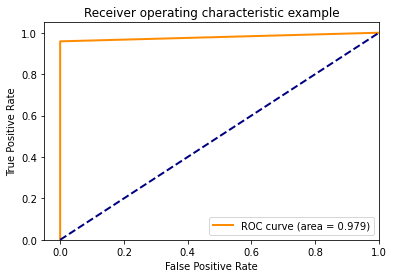

In [64]:
plt.figure()

plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="ROC curve (area = %0.3f)" % roc_auc,
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [65]:
m2 = EfficientNet.from_pretrained('efficientnet-b1')
# dummy_input = torch.randn(10, 3, 240, 240)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to C:\Users\user/.cache\torch\hub\checkpoints\efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b1


In [76]:
model = model.to('cpu')
torch.save(model.state_dict(), "efficientnet-b0-cpu.pch")

In [80]:
m2 = EfficientNet.from_name('efficientnet-b0')
num_ftrs = m2._fc.in_features
m2._fc = nn.Linear(num_ftrs, 1)
m2.load_state_dict(torch.load('efficientnet-b0.pch'))

<All keys matched successfully>